In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [65]:
# FIXME: Code duplication
def is_valid_directory(finn_dir, verbose=False):
    group_name_file = finn_dir.parent / "group_name.txt"
    if not group_name_file.exists():
        if verbose:
            print(f"{group_name_file} does not exist")
        return False, None

    pred_ret_dir = finn_dir / "predicted_retardations"
    if not pred_ret_dir.exists() or not list(pred_ret_dir.iterdir()):
        if verbose:
            print(f"{pred_ret_dir} does not exist or is empty")
        return False, None

    try:
        c_train = np.load(finn_dir / "c_train.npy")
        c_predictions = np.load(finn_dir / "c_train_predictions.npy")
    except FileNotFoundError:
        if verbose:
            print(f"{finn_dir} does not contain c_train.npy or c_train_predictions.npy")
        return False, None
    if np.mean((c_train - c_predictions) ** 2) > 1e-4:
        if verbose:
            print(f"{finn_dir} has too large MSE for c")
        return False, None

    all_ret_file_paths = sorted(
        (finn_dir / "predicted_retardations").glob("retPred_*.npy"),
        key=lambda x: int(x.stem.split("_")[-1]),
    )
    epoch = int(all_ret_file_paths[-1].stem.split("_")[-1])
    if epoch < 100:
        if verbose:
            print(f"{finn_dir} has too few epochs")
        return False, None
    last_pred_ret = np.load(all_ret_file_paths[-1])
    if (
        np.isnan(last_pred_ret).any() or np.isinf(last_pred_ret).any()
        # or np.any((last_pred_ret < 3) | (last_pred_ret > 20))
    ):
        if verbose:
            print(f"{finn_dir}'s last predicted retardation is invalid")
        return False, None

    # is d^2fdx^2 almost zero?
    dx = 1 / 100
    dfdx = np.diff(last_pred_ret, axis=0) / dx
    dfdx2 = np.diff(dfdx, axis=0) / dx
    if np.all(np.abs(dfdx2) < 10):
        if verbose:
            print(f"{finn_dir}'s last predicted retardation is almost a straight line")
        return False, None

    return True, all_ret_file_paths[-1]


def collect_valid_simulation_dirs(root_dir, verbose=False):
    valid_dirs = []
    for ret_dir in root_dir.rglob("predicted_retardations"):
        finn_dir = ret_dir.parent
        is_dir_valid, learned_ret_file_path = is_valid_directory(
            finn_dir, verbose=verbose
        )
        if is_dir_valid:
            group_name = (finn_dir.parent / "group_name.txt").read_text().strip()
            valid_dirs.append((finn_dir, group_name, learned_ret_file_path))
    return valid_dirs


def compute_mse(a, b):
    return np.mean((a - b) ** 2)

In [66]:
# A) Collect all valid simulation directories
root_dir = Path("../data_out_02092024")
valid_finn_dirs = collect_valid_simulation_dirs(root_dir, verbose=True)

records = []
for finn_dir, group_name, learned_ret_file_path in valid_finn_dirs:
    records.append(
        {
            "finn_dir": finn_dir,
            "group_name": group_name,
            "exp_label": f"{group_name}_{finn_dir.name}",
            "learned_ret_file_path": learned_ret_file_path,
            "analytical_ret_type": "langmuir"
            if "langmuir" in str(finn_dir)
            else "freundlich",
        }
    )

finn_dir_df = pd.DataFrame.from_records(records)
print(len(finn_dir_df))
finn_dir_df.head()

../data_out_02092024/langmuir/group_name.txt does not exist
../data_out_02092024/langmuir/finn_all_UQ_factors/673912496_cFullNoise_sigma=0.001_j=4_finn_all_UQ_factors's last predicted retardation is almost a straight line
../data_out_02092024/langmuir/finn_all_UQ_factors/695869966_cFullNoise_sigma=0.001_j=6_finn_all_UQ_factors's last predicted retardation is almost a straight line
../data_out_02092024/langmuir/finn_all_UQ_factors/110173383_cFullNoise_sigma=0.001_j=5_finn_all_UQ_factors's last predicted retardation is almost a straight line
../data_out_02092024/langmuir/finn_all_UQ_factors/761087777_cFullNoise_sigma=0.001_j=14_finn_all_UQ_factors's last predicted retardation is almost a straight line
../data_out_02092024/langmuir/finn_all_UQ_factors/750142680_cFullNoise_sigma=0.001_j=1_finn_all_UQ_factors's last predicted retardation is almost a straight line
../data_out_02092024/langmuir/finn_all_UQ_factors/115860018_cFullNoise_sigma=0.001_j=3_finn_all_UQ_factors does not contain c_tra

,finn_dir,group_name,exp_label,learned_ret_file_path,analytical_ret_type
0,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir
1,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_456204333_cFullNoise_sigma=0.001_j=2_fi...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir
2,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_802876658_cFullNoise_sigma=0.001_j=13_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir
3,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_776184014_cFullNoise_sigma=0.001_j=2_fi...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich
4,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_758040160_cFullNoise_sigma=0.001_j=9_fi...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich


In [67]:
# B) Compute MSE of c and ret for each simulation directory
mse_data = []
for _, row in finn_dir_df.iterrows():
    finn_dir = row["finn_dir"]
    c_full = np.load(finn_dir / "c_full.npy")
    c_train = np.load(finn_dir / "c_train.npy")
    c_train_predictions = np.load(finn_dir / "c_train_predictions.npy")
    c_full_predictions = np.load(finn_dir / "c_full_predictions.npy")
    # u_ret = np.load(finn_dir / "u_ret.npy")
    last_pred_ret = np.load(row["learned_ret_file_path"])
    analytical_ret = np.load(finn_dir / f"retardation_{row['analytical_ret_type']}.npy")

    mse_c_train = compute_mse(c_train, c_train_predictions)
    mse_c_full = compute_mse(c_full, c_full_predictions)
    mse_ret = compute_mse(analytical_ret, last_pred_ret)

    mse_data.append(
        {
            "exp_label": row["exp_label"],
            "mse_c_train": mse_c_train,
            "mse_c_full": mse_c_full,
            "mse_ret": mse_ret,
        }
    )

mse_df = pd.DataFrame(mse_data)
mse_df.head()

,exp_label,mse_c_train,mse_c_full,mse_ret
0,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,0.000009,0.000013,0.000385
1,All UQ_456204333_cFullNoise_sigma=0.001_j=2_fi...,0.000007,0.000014,0.001204
2,All UQ_802876658_cFullNoise_sigma=0.001_j=13_f...,0.000008,0.000012,0.001206
3,All UQ_776184014_cFullNoise_sigma=0.001_j=2_fi...,0.000006,0.000013,0.787397
4,All UQ_758040160_cFullNoise_sigma=0.001_j=9_fi...,0.000008,0.000019,0.786672


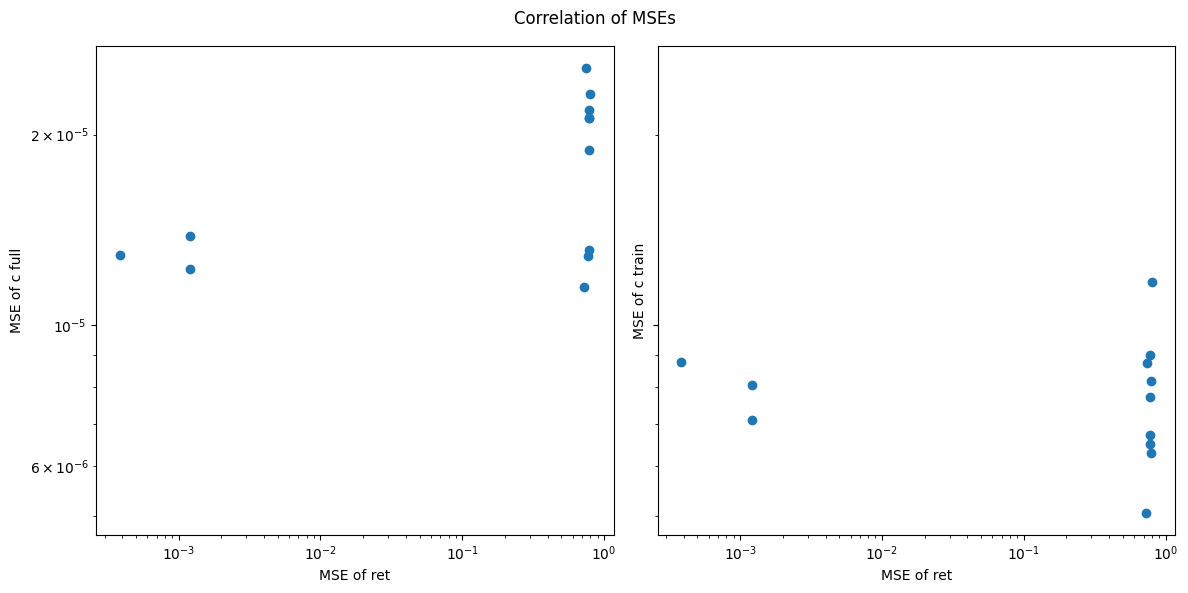

In [68]:
# Plot correlation of MSEs
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Correlation of MSEs")

ax1.scatter(mse_df["mse_ret"], mse_df["mse_c_full"])
ax2.scatter(mse_df["mse_ret"], mse_df["mse_c_train"])
for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("MSE of ret")
ax1.set_ylabel("MSE of c full")
ax2.set_ylabel("MSE of c train")

plt.tight_layout()
plt.show()

In [69]:
# C) Plot final retardations of each simulation directory
ret_df = finn_dir_df.copy()
ret_df["ret"] = finn_dir_df["learned_ret_file_path"].apply(lambda p: np.load(p).ravel())
ret_df = ret_df.explode("ret").reset_index(drop=True)
ret_df["u"] = np.tile(np.arange(0, 100), len(finn_dir_df))
ret_df["ret"] = ret_df["ret"].astype(np.float64)

In [70]:
ret_df

,finn_dir,group_name,exp_label,learned_ret_file_path,analytical_ret_type,ret,u
0,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,5.121493,0
1,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,5.039191,1
2,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,4.959439,2
3,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,4.882135,3
4,../data_out_02092024/langmuir/finn_all_UQ_fact...,All UQ,All UQ_253365502_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,4.807187,4
...,...,...,...,...,...,...,...
1195,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich,3.134637,95
1196,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich,3.131493,96
1197,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich,3.128423,97
1198,../data_out_02092024/freundlich/finn_all_UQ_fa...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out_02092024/freundlich/finn_all_UQ_fa...,freundlich,3.125427,98


In [84]:
analytical_rets = {
    x: np.load(finn_dir_df.iloc[0]["finn_dir"] / f"retardation_{x}.npy")
    for x in ["freundlich", "langmuir", "linear"]
}

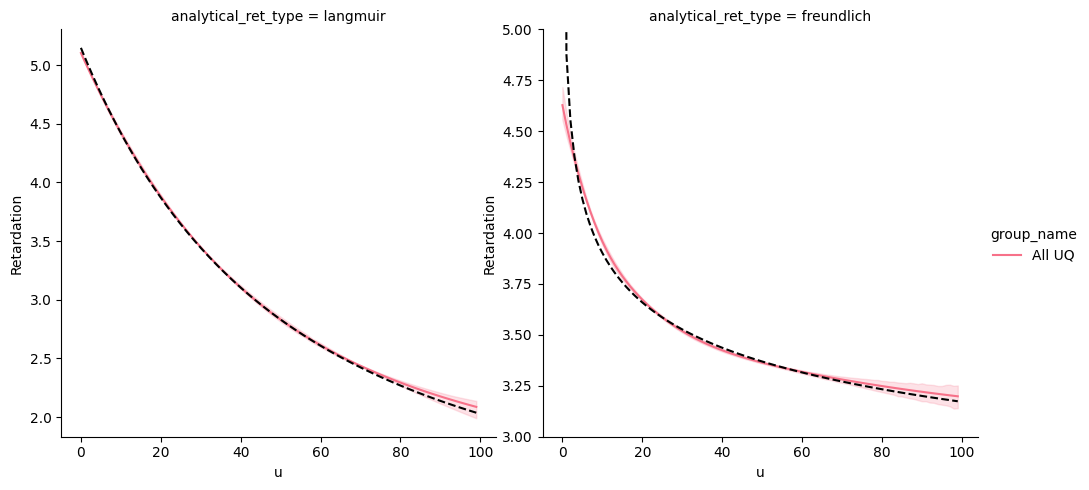

In [85]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    col="analytical_ret_type",
    # style="group_name",
    # markers=True,
    # dashes=False,
    # legend="brief",
    palette=sns.color_palette("husl", len(finn_dir_df["group_name"].unique())),
    facet_kws={"sharey": False},
)

for analytical_retardation_type, ax in g.axes_dict.items():
    ax.plot(
        analytical_rets[analytical_retardation_type],
        "k--",
        label=analytical_retardation_type.capitalize(),
    )
    if analytical_retardation_type.lower() == "freundlich":
        ax.set_ylim(3, 5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")

plt.show()

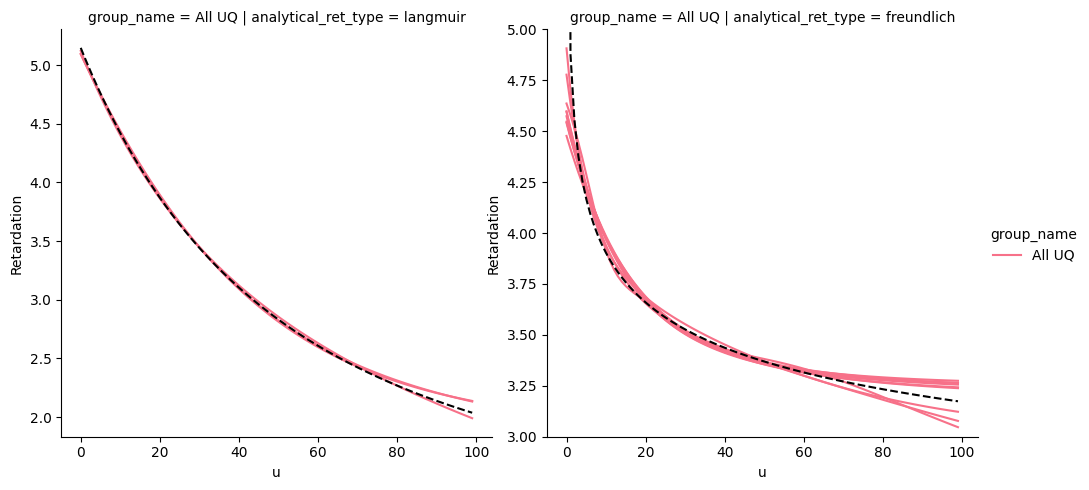

In [86]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    row="group_name",
    col="analytical_ret_type",
    units="exp_label",
    estimator=None,
    palette=sns.color_palette("husl", len(finn_dir_df["group_name"].unique())),
    facet_kws={"sharey": False},
)

for (_, analytical_retardation_type), ax in g.axes_dict.items():
    ax.plot(
        analytical_rets[analytical_retardation_type],
        "k--",
        label=analytical_retardation_type.capitalize(),
    )
    if analytical_retardation_type.lower() == "freundlich":
        ax.set_ylim(3, 5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")

plt.show()

In [87]:
# D) Compute enclosing (upper and lower) curves for each group
grouped_ret = ret_df.groupby(["group_name", "analytical_ret_type"])

enclosing_curves = []
for group_name, group in grouped_ret:
    group_ret = group.pivot(index="u", columns="exp_label", values="ret").values
    lower_curve = np.min(group_ret, axis=1)
    upper_curve = np.max(group_ret, axis=1)
    enclosing_curves.append(
        {
            "group_name": group_name,
            "lower_curve": lower_curve.astype(
                float
            ),  # Ensure the curves are float type
            "upper_curve": upper_curve.astype(float),
        }
    )

enclosing_df = pd.DataFrame(enclosing_curves)
enclosing_df.head()

,group_name,lower_curve,upper_curve
0,"(All UQ, freundlich)","[4.476705074310303, 4.413524627685547, 4.35358...","[4.9066572189331055, 4.7030792236328125, 4.540..."
1,"(All UQ, langmuir)","[5.094501495361328, 5.022701263427734, 4.95211...","[5.121492862701416, 5.039191246032715, 4.95943..."


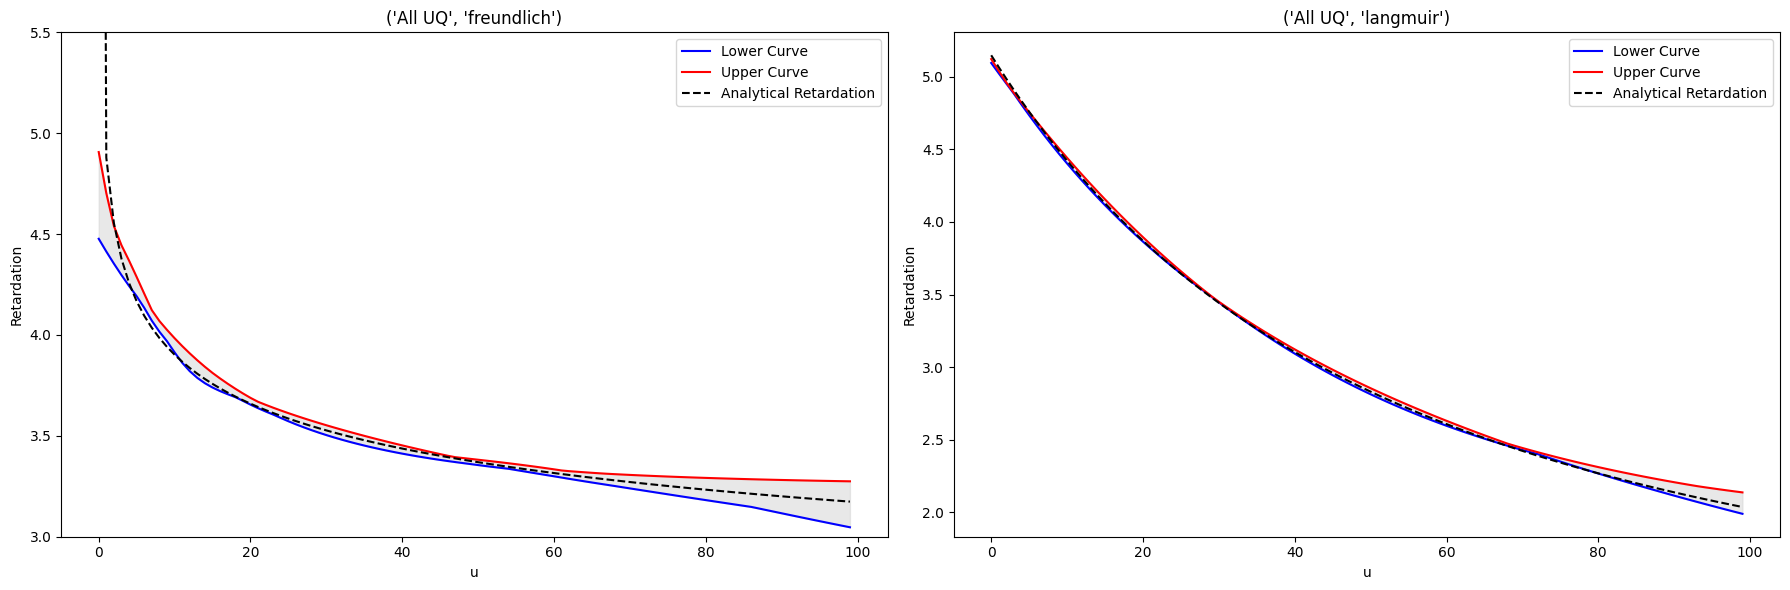

In [88]:
# E) Plot enclosing curves for each group pair in a single figure with NxM axes
num_groups = len(enclosing_df)
ncols = 2  # Number of columns in the plot grid
nrows = (num_groups + ncols - 1) // ncols  # Number of rows in the plot grid

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharey=False
)
axes = axes.flatten()

for i, (group_name, lower_curve, upper_curve) in enumerate(
    zip(
        enclosing_df["group_name"],
        enclosing_df["lower_curve"],
        enclosing_df["upper_curve"],
    )
):
    lower_curve = np.asarray(lower_curve)  # Ensure it's a numpy array
    upper_curve = np.asarray(upper_curve)  # Ensure it's a numpy array

    ax = axes[i]
    ax.fill_between(
        np.arange(len(lower_curve)),
        lower_curve,
        upper_curve,
        color="lightgray",
        alpha=0.5,
    )
    ax.plot(lower_curve, color="blue", label="Lower Curve")
    ax.plot(upper_curve, color="red", label="Upper Curve")
    analytical_retardation_type = (
        "langmuir" if "langmuir" in group_name else "freundlich"
    )
    ax.plot(
        analytical_rets[analytical_retardation_type],
        "k--",
        label="Analytical Retardation",
    )
    ax.set_title(group_name)
    if analytical_retardation_type == "freundlich":
        ax.set_ylim(3, 5.5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")
    ax.legend()

plt.tight_layout()
plt.show()


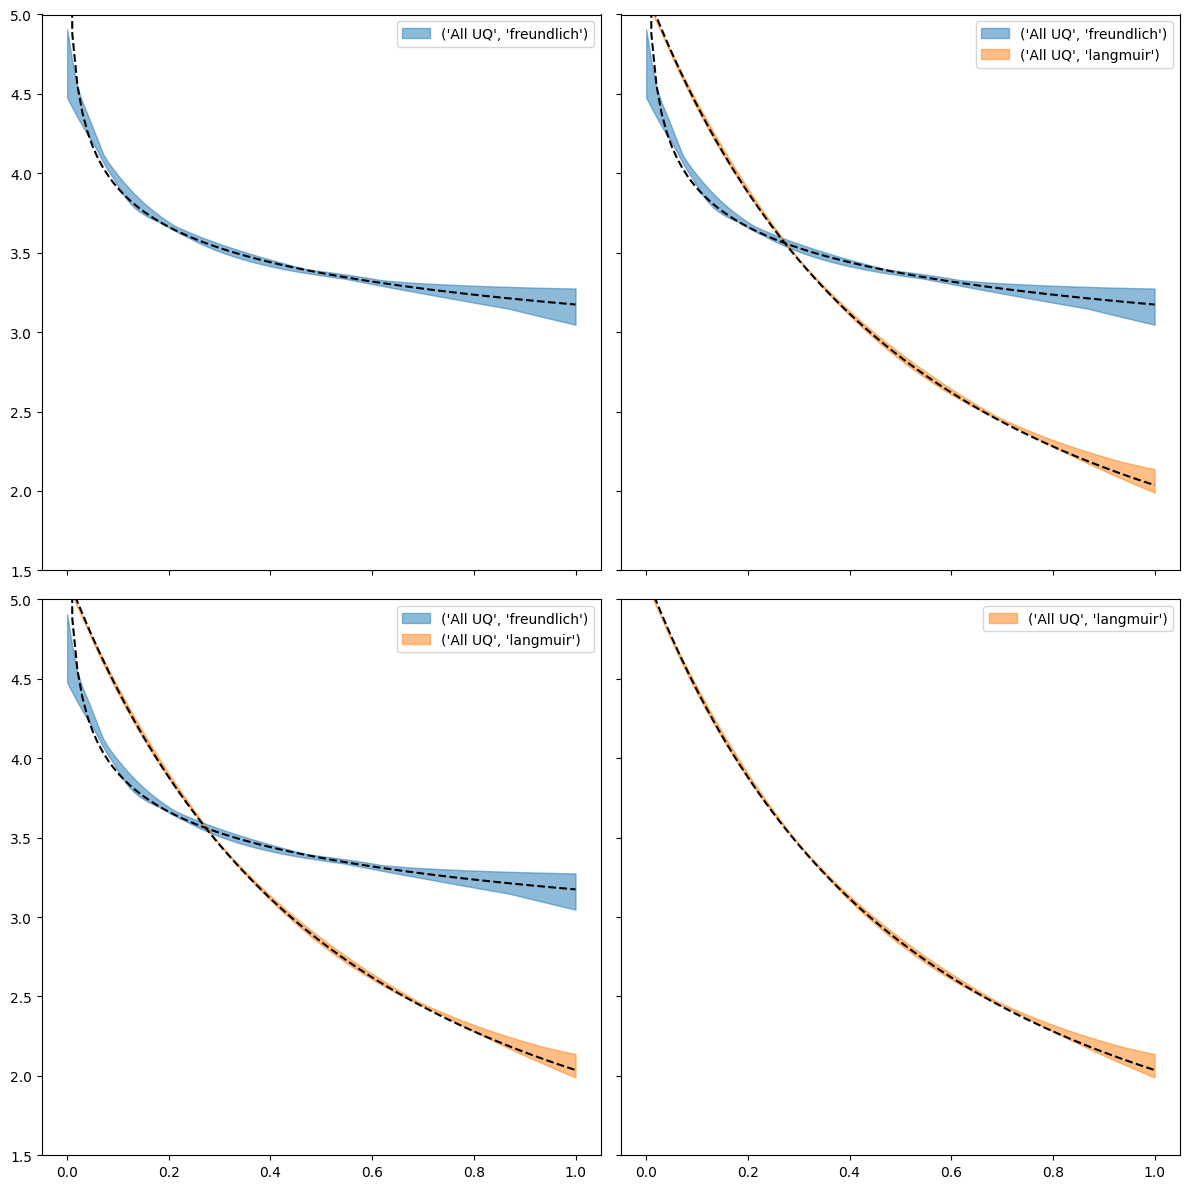

In [118]:
ALPHA_ENVELOPES = 0.5
ALPHA_CURVES = 0.3

# %% Compute and plot enclosing curves

ret_df_groups = ret_df.groupby(["group_name", "analytical_ret_type"])
num_groups = len(ret_df_groups)
fig, axes = plt.subplots(
    num_groups,
    num_groups,
    figsize=(4 * num_groups, 4 * num_groups),
    sharex=True,
    sharey=True,
)


for i, (group_labels, sub_ret_df) in enumerate(ret_df_groups):
    # ax = axes[i, j]
    # if i <= j:
    #     fig.delaxes(ax)  # Hide empty axes
    #     continue

    color = f"C{i}"

    analytical_retardation_type = group_labels[1]
    analytical_ret = analytical_rets[analytical_retardation_type]
    u = np.linspace(0, 1, analytical_ret.size)

    # Plot single curves
    # for exp_label in finn_dir_df[finn_dir_df["group_name"] == group1]["exp_label"]:
    #     ret = ret_df[ret_df["exp_label"] == exp_label]["ret"].values
    #     ax.plot(u, ret, color=color1, alpha=ALPHA_CURVES)
    # for exp_label in finn_dir_df[finn_dir_df["group_name"] == group2]["exp_label"]:
    #     ret = ret_df[ret_df["exp_label"] == exp_label]["ret"].values
    #     ax.plot(u, ret, color=color2, alpha=ALPHA_CURVES)

    # Compute and plot enclosing curves
    all_rets = sub_ret_df["ret"].to_numpy().reshape(-1, analytical_ret.shape[0])
    min_curve = np.min(all_rets, axis=0)
    max_curve = np.max(all_rets, axis=0)

    def plot_all(ax):
        ax.fill_between(
            x=u,
            y1=min_curve,
            y2=max_curve,
            color=color,
            alpha=ALPHA_ENVELOPES,
            label=group_labels,
        )

        # Plot enveloping curves
        # ax.plot(u, min_curve1, color=color1, linewidth=2)
        # ax.plot(u, max_curve1, color=color1, linewidth=2)
        # ax.plot(u, min_curve2, color=color2, linewidth=2)
        # ax.plot(u, max_curve2, color=color2, linewidth=2)

        # if analytical_retardation_type == "freundlich":
        ax.set_ylim(1.5, 5)

        ax.plot(u, analytical_ret, "k--")#, label="Analytical Retardation")

        ax.legend()

    for k in range(num_groups):
        row = i
        col = k
        plot_all(axes[row, col])

    for k in range(num_groups):
        row = k
        col = i
        if row == col:
            continue
        plot_all(axes[row, col])


# for ax in axes.flat:

plt.tight_layout()
plt.show()

# Sample Points between Curves for PI3NN

1287 are between for All UQ Langmuir
4371 are between for All UQ Freundlich


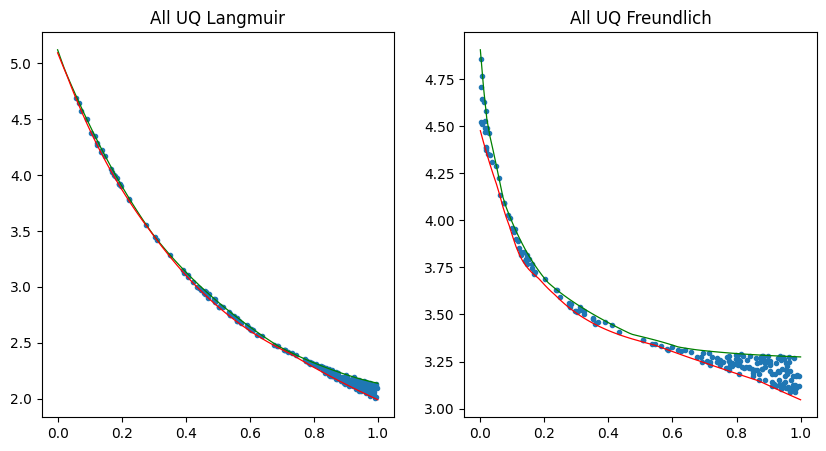

In [ ]:
from common import is_below_curve, is_above_curve

fig, axs = plt.subplots(1, len(groups), figsize=(5 * len(groups), 5))

group_envelope_points = {}

for i, group1 in enumerate(groups):
    u = np.linspace(0, 1, analytical_ret.size)

    # Compute enclosing curves
    ret_group = np.asarray(
        ret_df[ret_df["group_name"] == group1]["ret"].values.reshape(
            -1, analytical_ret.size
        )
    )
    envelope_curve_up = np.max(ret_group, axis=0)
    envelope_curve_down = np.min(ret_group, axis=0)

    # Sample points
    y_max = envelope_curve_up.max()
    y_min = envelope_curve_down.min()

    rng = np.random.default_rng(2864343564)
    rectangle_points = rng.uniform(low=0, high=1, size=(10**5, 2))
    rectangle_points[:, 1] = rectangle_points[:, 1] * (y_max - y_min) + y_min

    is_below = is_below_curve(u, envelope_curve_up, rectangle_points)
    is_above = is_above_curve(u, envelope_curve_down, rectangle_points)
    is_between = is_below * is_above

    envelope_points = rectangle_points[is_between].copy()
    group_envelope_points[group1] = envelope_points

    # Plot sampled points
    print(f"{len(envelope_points)} are between for {group1}")
    u = np.linspace(0, 1, len(envelope_curve_up))
    axs[i].plot(*envelope_points[:200].T, ".")
    axs[i].plot(u, envelope_curve_up, "g-", lw=0.9)
    axs[i].plot(u, envelope_curve_down, "r-", lw=0.9)
    axs[i].set_title(group1)

plt.show()

In [ ]:
# Save envelope points
for group, envelope_points in group_envelope_points.items():
    assert len(envelope_points) >= 500
    pinn_base_path = Path("../data_out/3pinn").resolve()
    pinn_dir = pinn_base_path / f"{group.replace(' ', '_')}"
    pinn_dir.mkdir(exist_ok=True, parents=True)
    pinn_x_path = pinn_dir / "x.npy"
    pinn_y_path = pinn_dir / "y.npy"

    np.save(pinn_x_path, envelope_points[:500, 0])
    np.save(pinn_y_path, envelope_points[:500, 1])